In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv('datasets/cars.csv')

data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [4]:
data.shape

(261, 8)

In [5]:
# On mélange le dataset en préservant les datapoints
data = data.sample(frac=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 7 to 190
Data columns (total 8 columns):
mpg             261 non-null float64
 cylinders      261 non-null int64
 cubicinches    261 non-null object
 hp             261 non-null int64
 weightlbs      261 non-null object
 time-to-60     261 non-null int64
 year           261 non-null int64
 brand          261 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 18.4+ KB


In [8]:
# Les colonnes object et cubicinches sont de types objects, on doit donc faire un prétraitement dessus
# Avant cela, on enlève les espaces qu'il y a dans certains labels de colonnes
data.columns = data.columns.str.lstrip()
data.columns

Index(['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time-to-60',
       'year', 'brand'],
      dtype='object')

In [9]:
# On cast les objets en int avec la fonction panda to_numeric
# errors='coerce' permet de remplacer toutes les valeurs qui n'ont pas pu être castée en Nan
data['cubucinches'] = pd.to_numeric(data['cubicinches'], errors='coerce')
data['weightlbs'] = pd.to_numeric(data['weightlbs'], errors='coerce')

In [11]:
# La fonctione dropna permet d'enlever du dataset toutes les lignes contenant des Nan
data.dropna(inplace=True)

In [12]:
data.shape

(256, 9)

In [16]:
# Il nous reste la colonne brand qui est une colonne de string : il faut convertir ca en int 
# pour nos algorithm : comme d'habitude, on applique le LabelEncoder
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
data['brand'] = labelEncoder.fit_transform(data['brand'].astype(str))

data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand,cubucinches
7,14.0,8,440,215,4312.0,9,1971,2,440.0
99,16.0,6,250,100,3781.0,17,1975,2,250.0
215,32.9,4,119,100,2615.0,15,1982,1,119.0
104,32.2,4,108,75,2265.0,15,1981,1,108.0
156,18.0,3,70,90,2124.0,14,1974,1,70.0


In [18]:
# Notre dataset est pret : on choisit les colonnes que l'on inclue dans notre catégorisation
data_x = pd.DataFrame(data, columns = ['mpg', 'cubicinches', 'cylinders', 'hp'])
# On utilise la marque comme label en y
label_y = data['brand']

Text(0, 0.5, 'Weight')

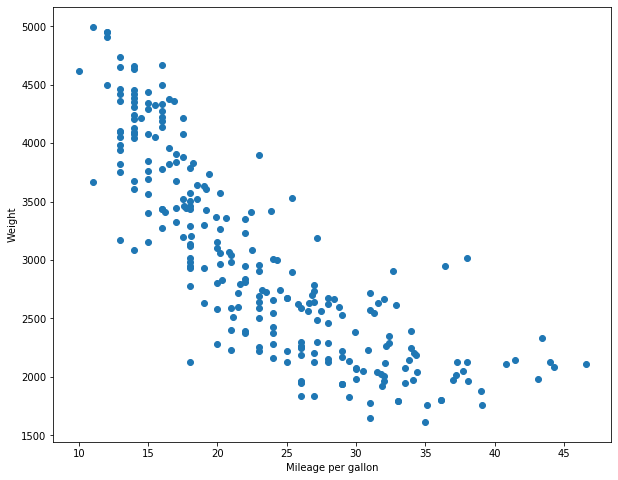

In [19]:
# On ne peut pas tout afficher ici mais on affiche un scatter plot entre la consomation (miles 
# per gallion) et le poids
plt.figure(figsize=(10,8))

plt.scatter(data['mpg'], data['weightlbs'])

plt.xlabel("Mileage per gallon")
plt.ylabel("Weight")

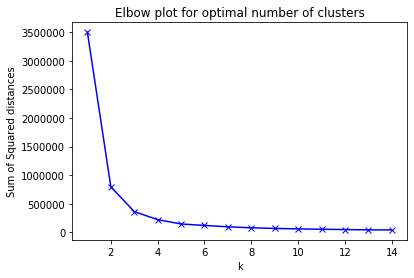

In [52]:
# On veut mainteant appliquer notre Kmean classifier mais on ne sait pas trop quel 
# est le nombre de categories à choisir pour obtenir le meilleur résultat
# On applique donc l'algo sur les valeurs de 1 à 15 centres puis on choisit celui pour lesquels
# les catégories sont les plus compactes
from sklearn.cluster import KMeans

sum_of_squared_distances = []

K = range(1,15)

for k in K:
    # On construit notre model
    k_means = KMeans(n_clusters=k)
    k_means = k_means.fit(data_x)
    
    # On entre l'inertie qui ne permet de mesurer a quel point les catégories sont compactes
    # ie le model est bon
    sum_of_squared_distances.append(k_means.inertia_)
    
# On affiche ces infos dans un graphe
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared distances')

# Ce graphe est appelé coude car il dessine un coude et c'est la valeur qui fait l'angle qui
# est celle que l'on doit choisir ici on peut voir que c'est 3
plt.title('Elbow plot for optimal number of clusters')
plt.show()

In [53]:
# On applique maintenant le KMeans avec la valeur 3 que nous avons trouvé être la meilleure
k_means = KMeans(n_clusters=3)
k_means = k_means.fit(data_x)

In [54]:
# On calcul maitenant le Silhouette Score pour voir a quel point notre model est satisfaisant
# Le silhoutte score mesure a peut pret comme l'inertie
from sklearn.metrics import silhouette_score

score = silhouette_score(data_x, k_means.labels_)

print("Score = ", score)

Score =  0.6323149311159748


In [56]:
# Un autre moyen de mesurer le score de notre classificateur et l'homogénéité
# L'homogenieté mesure si chaque cluster contient seuleument 1 seul type de valeur contenue dans y
from sklearn.metrics import homogeneity_score

hmg_score = homogeneity_score(label_y, k_means.labels_)

print("Homogeneity Score = ", hmg_score)

Homogeneity Score =  0.31550036277564175


In [58]:
# Un autre moyen de mesure est le vmeasure_score : la moyenne hamonique entre le socre 
# d'homogenieté et le completeness score que l'on va voir juste apres
from sklearn.metrics import v_measure_score

vm_score = v_measure_score(label_y, k_means.labels_)

print("V Measure Score = ", vm_score)

V Measure Score =  0.3003375614022765


In [60]:
# Le completeness mesure si tous les points appartenant à la meme classe (dans y) appartiennent
# Au meme cluster
from sklearn.metrics import completeness_score

comp_score = completeness_score(label_y, k_means.labels_)

print("Completeness Score = ", comp_score)

Completeness Score =  0.28656536273532296


In [63]:
# Une autre methode est le adjusted_rand_score : Mesure la similaritée entre les cluster avec un
# facteur "chance" qui est dirigé par est-ce que le label en y est correct

# Quand les clusters ont été attribués de maniere complemente aléatoire comparer a notre label
# y, le score est proche de 0. Si les cluster match assez bien avec notre label y, le score est 
# proche de 1 

from sklearn.metrics import adjusted_rand_score

adj_r_score = adjusted_rand_score(label_y, k_means.labels_)

print("Adjusted Rand Score = ", adj_r_score)

Adjusted Rand Score =  0.11281925794858025


In [66]:
# Une dernire metrics est le ajdusted_mutual_info_score : On observe une variable aléatoire
# en observant une autre variable aléatoire
# Aucune idée de ce que ca veut dire, a creuser
from sklearn.metrics import adjusted_mutual_info_score

adj_mutual_score = adjusted_mutual_info_score(label_y, k_means.labels_, average_method='arithmetic')

print("Adjusted mutual Score = ", adj_mutual_score)

Adjusted mutual Score =  0.29459818425329665
